In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Contrastive Hebbian Learning

Contrastive Hebbian Learning (CHL) is an algorithm that can be used to perform supervised learning in a neural network. It unites the power of backpropagation with the plausibility of Hebbian learning, and is thus a favorite of researchers in computational neuroscience. In terms of power, Xie (2006) has shown that, under most conditions, CHL is actually equivalent to backpropagation. 

## "Learn" and "Unlearn" phases

CHL works by performing Hebbian updates in two distinct phases, which are indicated as the __Learn__ (+) or the __Unlearn__ (-) phases. Synapcti weights are updated according to the difference of the two phases:

$$
w_{i,j} \leftarrow w_{i,j} + \eta (y^+_i y^+_j - y^-_i y^-_j) 
$$

Where $y$ represents, as usual, the output of a neuron.

## Synchronous and Asynchronous

In the canonical equation (above), the two terms $y^+_i y^+_j$ and $-y^-_i y^-_j$ are computed at different times but updated at the same moment. Because of this, the canonical form is called __synchronous__. This form is efficient but implausible, because it requires storing the products $y^+_i y^+_j$ and $-y^-_i y^-_j$ until the update is performed.

An more plausible alternative is to perform __asynchronous__  updates, with the product $y_i y_j$ because calculated and used immediately (just like in canonical Hebbian learning) and the sign of the update being dependent upon the phase.  

$$
w_{i,j} \leftarrow w_{i,j} +
\begin{cases}
 + \eta (y_i y_j) & \mathrm{if~phase~is "Learn"} \\
 - \eta (y_i y_j) & \mathrm{if~phase~is "Unlearn"} 
\end{cases}
$$

## Connectivity 

Because of its very nature, CHL requires the network to be __recurrent__, that is, synaptic matrices that connect two adjacent layers both forward and backward.   

In turn, recurrent networks are intrinsically unstable, as require multiple passes to converge towards a stable solution. The number of passes is sometimes used as a proxy for response times or similar behavioral measures.

## The Network

The CHL version of the XOR network is defined in these few lines of code. 

In [50]:
n_input  = 2
n_hidden  = 4
n_output = 1

eta = 0.3   # Learning rate. This is higher than usual.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

x    = np.zeros((1, n_input))                               # Input layer
h    = np.zeros((1, n_hidden))                              # Hidden layer
o    = np.zeros((1, n_output))                              # Output layer
w_xh = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
w_ho = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses
w_oh = (np.random.random((n_output, n_hidden)) / 5) - 0.1   # Second layer of synapses


Here are the functions that support the network

In [65]:
def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

def set_inputs(pattern):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(pattern).reshape((1,n_input))
    
def set_outputs(vals):
    """Sets the output variables"""
    global o
    o = vals

def target(val):
    """Desired response function, t(p)"""
    if  val == [0, 1] or val == [1, 0]:
        return np.array([[1.0]])
    else:
        return np.array([[0.0]])

def error(p1, p2):
    """Calculates the error function"""
    return 0.5 * np.sum(((p1 - p2) ** 2))

    
def propagate(clamped_output = False):
    """Spreads activation through a network"""
    global h
    global o
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w_xh) + np.dot(o, w_oh) 
    h = logistic(h_input)
    
    if not clamped_output:
        output_input = np.dot(h, w_ho)
        o = logistic(output_input)

        
def activation(clamped_output = False, convergence = 0.00001, max_cycles = 250):
    """Spreads activation through a network until it settles"""
    previous_h = np.copy(h)
    propagate(clamped_output)
    diff = error(previous_h, h)
    i = 1
    
    while diff > convergence and i < max_cycles:
        previous_h = np.copy(h)
        propagate(clamped_output)
        diff = error(previous_h, h)
        i += 1
    return i


def calculate_response(p):
    """Calculate the response for a given network's input"""
    global o
    set_inputs(p)
    activation(False)
    return np.sum(o)


def chl_pos():
    """Positive Hebbian update (unlearn)"""
    global w_xh, w_ho, w_oh
    w_xh += eta * (x.T.dot(h))
    w_ho += eta * (h.T.dot(o))
    w_oh += eta * (o.T.dot(h))
    
    
def chl_neg():
    """Negative Hebbian update (unlearn)"""
    global w_xh, w_ho, w_oh
    w_xh -= eta * (x.T.dot(h))
    w_ho -= eta * (h.T.dot(o))
    w_oh -= eta * (o.T.dot(h))


def asynchronous_chl(min_error = 0.001, max_epochs = 100):
    """Learns associations by means applying CHL asynchronously"""
    E = [min_error + 1]  ## Initial errir value > min_error
    epochs = 0
    global o
    while E[-1] > min_error and epochs < max_epochs:
        e = 0.0
        for p in patterns:
            set_inputs(p)
            set_outputs(target(p))
            activation(True)
            chl_pos()
            
            set_inputs(p)
            activation(False)
            e += error(target(p), o)
            print([p, target(p), o, error(target(p), o)])
            chl_neg()
        print(e)
        E.append(e)
        epochs += 1
    return E[1:]

### Test of CHL 

Here is a simple test of (asynchronous) CHL:

In [66]:
x    = np.zeros((1, n_input))                               # Input layer
h    = np.zeros((1, n_hidden))                              # Hidden layer
o    = np.zeros((1, n_output))                              # Output layer
w_xh = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
w_ho = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses
w_oh = (np.random.random((n_output, n_hidden)) / 5) - 0.1   # Second layer of synapses

E = asynchronous_chl(min_error = 0.0001, max_epochs = 100)

[[0, 0], array([[0.]]), array([[0.51487083]]), 0.13254598471856066]
[[0, 1], array([[1.]]), array([[0.5545451]]), 0.09921503217576633]
[[1, 0], array([[1.]]), array([[0.58566197]]), 0.0858380030354873]
[[1, 1], array([[0.]]), array([[0.53282685]]), 0.1419522246296709]
0.4595512445594852
[[0, 0], array([[0.]]), array([[0.48452102]]), 0.11738030730313648]
[[0, 1], array([[1.]]), array([[0.51875164]]), 0.11579999331179514]
[[1, 0], array([[1.]]), array([[0.55038182]]), 0.10107825239855146]
[[1, 1], array([[0.]]), array([[0.50322518]]), 0.126617789041293]
0.46087634205477607
[[0, 0], array([[0.]]), array([[0.46347533]]), 0.10740469079125116]
[[0, 1], array([[1.]]), array([[0.4949666]]), 0.12752936876553025]
[[1, 0], array([[1.]]), array([[0.52614594]]), 0.11226883608682288]
[[1, 1], array([[0.]]), array([[0.48390961]]), 0.11708425504903336]
0.46428715069263765
[[0, 0], array([[0.]]), array([[0.44829106]]), 0.10048243886054137]
[[0, 1], array([[1.]]), array([[0.47847448]]), 0.13599443348792

And here is a plot of the error function and the network's learned outputs

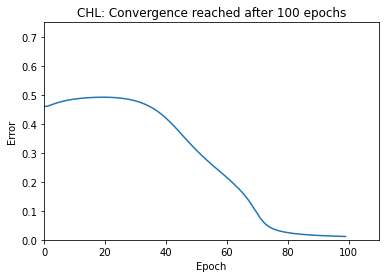

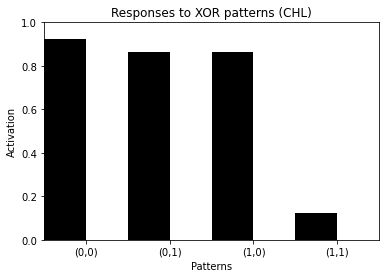

[0.8504709226923098,
 0.38303903624144275,
 0.3819264060290378,
 0.7695707026573678]

In [67]:
# Plot the Error by epoch

plt.plot(E)
plt.title("CHL: Convergence reached after %d epochs" %(len(E)))
plt.axis([0, len(E) + 10, 0, 0.75])
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

## Plot the responses to the XOR patterns

y_end = [calculate_response(p) for p in patterns]
y_err = [error(p, calculate_response(p)) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4) - 0.25, y_end, 0.5, color='black')
ax.set_title("Responses to XOR patterns (CHL)")
plt.show()
y_err

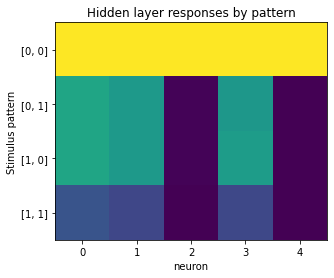

In [36]:
res = np.zeros((len(patterns), h.size))

for p in patterns:
    calculate_response(p)
    i = patterns.index(p) 
    res[i] = h

    
plt.imshow(res, interpolation = "none")
plt.title("Hidden layer responses by pattern")
plt.yticks(np.arange(4), patterns)
plt.ylabel("Stimulus pattern")
plt.xlabel("neuron")
plt.show()
